# Face Recognition Using Eigenfaces

## Training

1. Read dataset, calculate the mean face

2. Calculate covariance matrix

3. Select top k eigenvalues and eigenvectors

4. Calculate Euclidean distance

5. Classification, metrics, confusion matrix(Recall, Precision)

6. Reconstruct eigenfaces for visualization

7. Recognize test images from internet


## (Optional) Real-time recogntion

1. Detection: Open-CV

2. Recogntion: PCA

In [93]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

import os
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

In [94]:
# Only use people with more than 70 images, default resize=0.5
# Is data normalized here?
lfw_people = fetch_lfw_people(data_home=".", min_faces_per_person=70, resize=1)
n_samples, h, w = lfw_people.images.shape

# Use the 1-D pixels as features, positions info is ignored
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("#Samples: %d" % n_samples)
print("#Features Dimention: %d" % n_features)
print("#Classes: %d" % n_classes)

# X: (N x d), N: number of samples, d: feature dimention
print("X shape (N, d):", X.shape)
print(f"Image h, w: {h}, {w}")

#Samples: 1288
#Features Dimention: 11750
#Classes: 7
X shape (N, d): (1288, 11750)
Image h, w: 125, 94


In [95]:
def plot_gallery(X, titles, n_row=3, n_col=4):
    """ Helper function to plot a gallery of portraits """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(X[i].reshape(h, w), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([])
        plt.yticks([])
    plt.show()

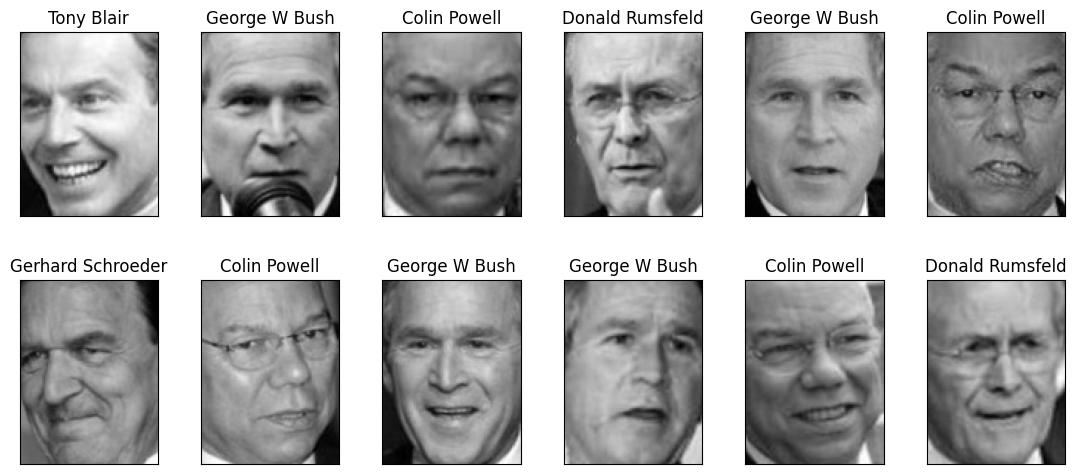

In [96]:
np.random.seed(0)
idx = np.random.randint(0, n_samples, 12)
plot_gallery(X[idx], target_names[y[idx]], n_row=2, n_col=6)

In [97]:
def mean_face(X):
    """ Compute the mean face """
    return np.mean(X, axis=0)

Mean face shape: (11750,)


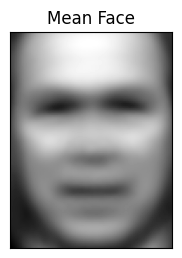

In [98]:
mean = mean_face(X)
mean1=mean
print("Mean face shape:", mean.shape)
plot_gallery([mean], ["Mean Face"], n_row=1, n_col=1)

In [99]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
mean = mean_face(X)

In [100]:
def cov_matrix(X, mean):
    """ Compute the covariance matrix  """
    sub = X - mean
    cov= np.dot(sub.T, sub)
    return cov / len(X)

    # Trick: (N,d x d,N = N,N), calculating eigenvectors cost 2.6s. But the result is problematic.
    # (d,N x N,d = d,d), calculating eigenvectors cost 8mins 14s.
    # Quesiton: d eigenvalues VS N eigenvalues?
    
    # cov = np.dot(sub, sub.T)
    # return cov / len(X)

In [101]:
cov = cov_matrix(X, mean)
is_symmetric = np.allclose(cov, cov.T)
print("Covariance matrix is symmetric", is_symmetric)
print("Covariance matrix shape:", cov.shape)
print(cov[0][:20])

Covariance matrix is symmetric True
Covariance matrix shape: (11750, 11750)
[0.9999997  0.9835104  0.94155824 0.89518124 0.84247357 0.7855158
 0.7228094  0.66162485 0.6083959  0.57124096 0.53730714 0.514708
 0.5019014  0.4895812  0.47645527 0.46166182 0.44699264 0.4338351
 0.42183703 0.40904933]


In [102]:
def eigen(X, mean):
    """ Compute the eigenvalues and eigenvectors """
    # Compute covariance matrix
    cov = cov_matrix(X, mean)
    # Compute normalized eigenvectors and eigenvalues of covariance matrix
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html#numpy.linalg.eigh
    # eigh: 3m 6s, eig: 8m 14s
    if not os.path.exists('eigval.npy') or not os.path.exists('eigvec.npy'):
        eigval, eigvec = LA.eigh(cov)
        # Save eigenvalues and eigenvectors
        np.save('eigval.npy', eigval)
        np.save('eigvec.npy', eigvec)
    else:
        eigval = np.load('eigval.npy')
        eigvec = np.load('eigvec.npy')
    return eigval, eigvec

    # eigval, eigvec = LA.eigh(cov)
    # # Convert to the original eigenvectors, (d, N)
    # eigvec = np.dot(X.T, eigvec)
    # # Get norms of each row
    # row_norm = LA.norm(eigvec, axis=1)
    # # Reshape to broadcast
    # eigvec = eigvec / row_norm.reshape(-1, 1)
    # return eigval, eigvec

In [103]:
eigval, eigvec = eigen(X, mean)
print("Eigenvalues shape:", eigval.shape)
print("Eigenvectors shape:", eigvec.shape)

Eigenvalues shape: (11750,)
Eigenvectors shape: (11750, 11750)


In [105]:
def PCA(X, mean, k=150):
    """ Principal components analysis with top k components """
    eigval, eigvec = eigen(X, mean)
    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigval)[::-1][:k]
    eigface = eigvec[:,idx]
    # Compute weights
    weights = np.dot(X - mean, eigface)
    return eigface, weights

Eigenfaces shape: (11750, 150)
Weights shape: (1288, 150)


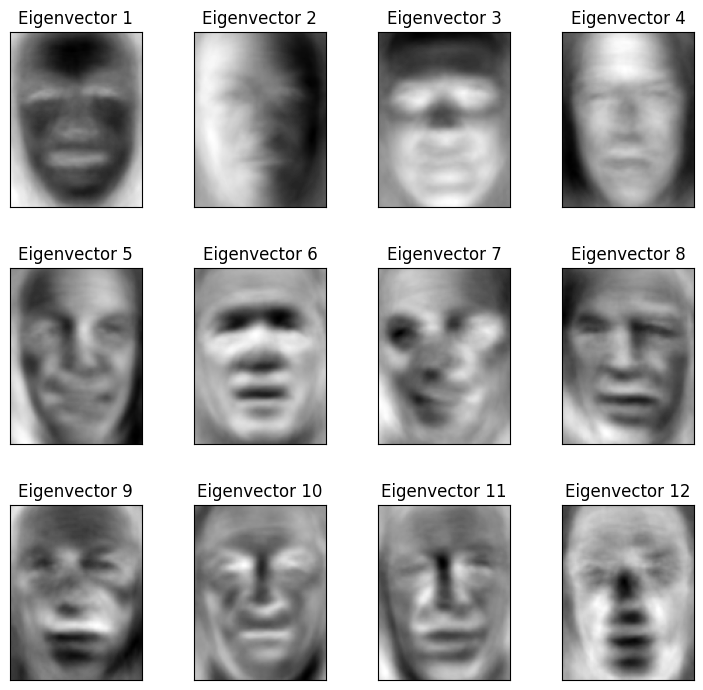

In [106]:
eigface, weights = PCA(X, mean)
print("Eigenfaces shape:", eigface.shape)
print("Weights shape:", weights.shape)
# Visualization of principal components
plot_gallery(eigface[:,:12].T, ["Eigenvector %d" % i for i in range(1, 13)])

In [107]:
def project(X, mean, eigface):
    """ Project input image onto eigenfaces """
    # Subtract mean face
    sub = X - mean
    return np.dot(sub, eigface)

def euclidean(proj, weights):
    """ Compute the Euclidean distance between projection and training weights """
    dist = []
    if len(proj.shape) == 1:
        proj = proj.reshape(1, -1)
    for p in proj:
        sub = p - weights
        d = LA.norm(sub, axis=1)
        dist.append(d)
        # print(d.shape)
    return np.array(dist)

In [108]:
proj = project(X, mean, eigface)
print("Projected shape:", proj.shape)
dist = euclidean(proj, weights)
print("Euclidean distance shape:", dist.shape)

Projected shape: (1288, 150)
Euclidean distance shape: (1288, 1288)


In [110]:
def pipeline(X_train, X_dev, y_train, y_dev, k = 150):
    """ Pipeline for face recognition using eigenfaces """
    # Compute mean face
    mean = mean_face(X_train)
    # Compute eigenfaces and weights
    eigface, weights = PCA(X_train, mean, k)
    # Project development images onto eigenfaces
    proj = project(X_dev, mean, eigface)
    # Compute Euclidean distance
    dist = euclidean(proj, weights)
    # Find the smallest distance of each dev image
    idx = np.argmin(dist, axis=1)
    # Get the predicted labels
    y_pred = y_train[idx]
    print(classification_report(y_dev, y_pred, target_names=target_names))
    ConfusionMatrixDisplay.from_predictions(y_dev, y_pred, display_labels=target_names, xticks_rotation='vertical')
    plt.tight_layout()
    plt.show()

                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.38      0.37        13
     Colin Powell       0.64      0.58      0.61        60
  Donald Rumsfeld       0.45      0.56      0.50        27
    George W Bush       0.74      0.68      0.71       146
Gerhard Schroeder       0.37      0.40      0.38        25
      Hugo Chavez       0.55      0.40      0.46        15
       Tony Blair       0.35      0.44      0.39        36

         accuracy                           0.58       322
        macro avg       0.49      0.49      0.49       322
     weighted avg       0.60      0.58      0.59       322



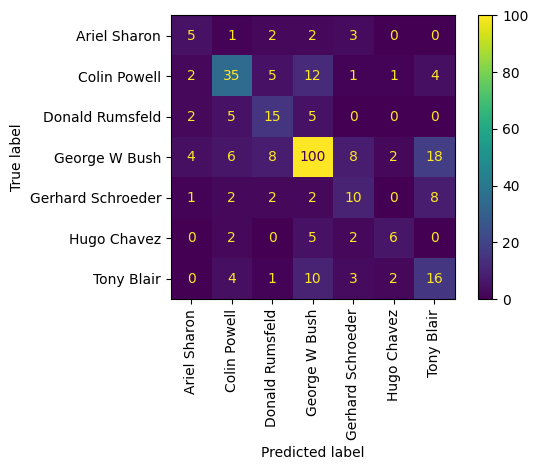

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pipeline(X_train, X_test, y_train, y_test)

## SVM Classifier

In [19]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k = 150
print(f"Extracting the top {k} eigenfaces from {len(X_train)} faces")
mean = mean_face(X_train)
eigface, weights = PCA(X_train, mean, k)
print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = weights
X_test_pca = project(X_test, mean, eigface)

print(X_train_pca[0][:20])

Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis
[-59.7308    -45.058727   19.996323  -45.39368    -3.6561904 -21.447832
 -15.828632   -0.5601337 -10.059246    9.831731    0.9180495  36.184025
 -10.152297   24.837994    4.548541  -36.946426  -17.078447    7.8903503
  -8.232038    2.1483567]


In [20]:
print("Fitting the classifier to the training set")
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=8899.40392888695, class_weight='balanced', gamma=0.00012801427626316938)


Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.82      0.85      0.84        60
  Donald Rumsfeld       0.84      0.59      0.70        27
    George W Bush       0.78      0.97      0.87       146
Gerhard Schroeder       0.81      0.68      0.74        25
      Hugo Chavez       1.00      0.33      0.50        15
       Tony Blair       0.88      0.64      0.74        36

         accuracy                           0.81       322
        macro avg       0.86      0.67      0.73       322
     weighted avg       0.82      0.81      0.80       322



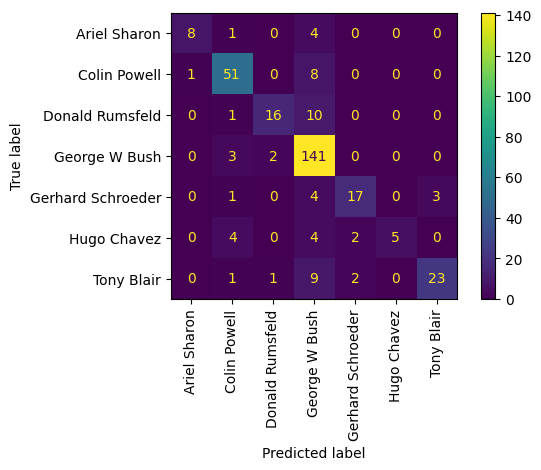

In [21]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Reconstruct

(10, 11750)


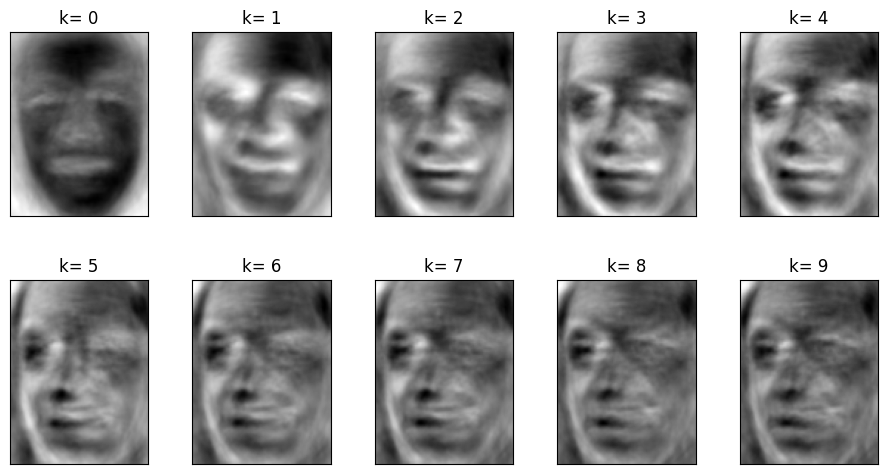

In [217]:
#reconstruct first image with eigenfaces of whole dataset
Y=[0]*10
for k, i in zip([1,15,30,45,60,75,90,105,120,135],np.arange(10)):
    face_score = X[0,:].dot(eigface[:,:k]) 
    projected_face = face_score.dot(eigface[:,:k].T)
    Y[i]=projected_face +mean1

plot_gallery(Y,["k= %d" % j for j in range(15) ], n_row=2, n_col=5)
